# Homework 3 - CNN on Multilabel remote sensing images
## By: Syed Ali Murad Tahir

In this homework we will be performing CNN on UCMerced dataset. This dataset contains Multispectral images. 

Tasks for this homework:
1) Importing data
2) Training data
3) Data Augmentation on training data
4) 




The task is divided into following step

1)  Prepairing data
2) The data we get, we divide that data, into training, test and validation. We divide training data into training and test
3) To pretrain the model in order to avoid overfitting, we can use pretrained data already provided to us. Or, we can perform data augmentation
to pre train the data so we have more samples of data
4) Now we perform Convolution. So we choose the number of layers, neuron in that layer and the activation function of that layer (Check if need to perform padding before,). For padding check the following link: https://www.youtube.com/watch?v=mTVf7BN7S8w&list=PLeo1K3hjS3uu7CxAacxVndI4bE_o3BDtO&index=27
5) Then we add Max pooling to take out dominant features
6) We can add dropout
7) Then we have to perform flatten the data
8) We can add a desne layer (Check if we need it or not) -> These are actually the hidden layers we specify when performing forward propgation
9) Then we train or data
10) After that we check our results on test data to check for overfitting
11) At the end we check validation


# Importing Dataset

## Understanding the dataset

This is a 21 class land use image dataset meant for research purposes.

There are 100 images for each of the following classes:

1) agricultural
2) airplane
3) baseballdiamond
4) beach
5) buildings
6) chaparral
7) denseresidential
8) forest
9) freeway
10) golfcourse
11) harbor
12) intersection
13) mediumresidential
14) mobilehomepark
15) overpass
16) parkinglot
17) river
18) runway
19) sparseresidential
20) storagetanks
21) tenniscourt

Each image measures 256x256 pixels.



In [5]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [6]:
import copy
import os
import numpy as np
import pandas as pd
import splitfolders
from pathlib import *
import zipfile
import matplotlib.pyplot as plt
from simple_downloader import download
from tqdm.notebook import tqdm
from pathlib import Path
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix



import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, Subset, DataLoader

In [7]:
#For removing directory and all files inside the directory. 
""" I created it so I don't have to delete all the files one by one in case I need to empty the folder"""
"""
path = os.path.join("/notebooks", "Hw3_data", "")
for root, dirs, files in os.walk(path, topdown=False):
    for name in files:
        os.remove(os.path.join(root, name))
    for name in dirs:
        os.rmdir(os.path.join(root, name))

"""

os.chdir("/notebooks")

In [8]:
class UCMerced(Dataset):
    def __init__(self, root_dir, img_transform=None, multilabel=True):

        self.root_dir = root_dir
        self.images_path = os.path.join(root_dir, "Images")
        self.class_names = sorted(
            [cl for cl in os.listdir(self.images_path) if not cl.startswith(".")]
        )
        self.img_paths, self.img_labels = self.init_dataset()
        self.img_transform = img_transform

        if multilabel:
            self.img_labels = self.read_multilabels()  # important for loss calculation
            self.img_labels = self.img_labels.astype(float)

    def init_dataset(self):
        img_paths, img_labels = [], []
        for cl_id, cl_name in enumerate(self.class_names):
            cl_path = os.path.join(self.images_path, cl_name)

            for img in sorted(os.listdir(cl_path)):
                img_path = os.path.join(cl_path, img)
                img_paths.append(img_path)
                img_labels.append(cl_id)

        return img_paths, img_labels

    def read_multilabels(self):
        pass

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.img_labels[idx]

        img = Image.open(img_path).convert("RGB")
        if self.img_transform is not None:
            img = self.img_transform(img)

        return dict(img=img, label=label)

    def __len__(self):
        return len(self.img_paths)

In [9]:
class MetricTracker(object):
    """Computes and stores the average and current value."""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.coun

In [10]:
def get_dataset(root_dir, tr_transform, te_transform, set_sizes, seed=1, multilabel=True):
    """
    Parameter
    ---------
    root_dir     : path to UCMerced Dataset
    tr_transform : transformation for training data
    te_transform : transformation for training data
    set_sizes    : list of percentage of either train-test or train-val-test (sum to 100)

    Output
    ------
    sets for train and test, optionally also val if len(set_sizes)==3
    """
    ucm_dataset_tr = UCMerced(root_dir, img_transform=tr_transform, multilabel=multilabel) #Divide dataset into training and test and transform the images
    ucm_dataset_te = UCMerced(root_dir, img_transform=te_transform, multilabel=multilabel)
    idx_list = split_ucm_indices(set_sizes, seed=seed) 

    train_set = Subset(ucm_dataset_tr, idx_list[0])
    test_set = Subset(ucm_dataset_te, idx_list[-1])

    if len(idx_list) > 2:
        val_set = Subset(ucm_dataset_te, idx_list[1])
        return train_set, val_set, test_set
    else:
        return train_set, test_set

In [11]:
"""
def split_ucm_indices(set_sizes, num_samples=2100, num_classes=21, seed=1):
    cl_samples = randint(50, 100) #Since we have multilabel so we select images between 50 and 100 for each class
    split_indices = list(map(int, np.cumsum(set_sizes)[:-1] / 100 * cl_samples))
    # class_idx_mat d x N (row: classes, columns: idx of sample in dataset)
    dataset_idx = np.arange(0, num_samples)
    class_idx_mat = np.reshape(dataset_idx, (num_classes, cl_samples))
    # random shuffle class_wise idx (=> per row)
    np.random.seed(seed)
    np.apply_along_axis(np.random.shuffle, 1, class_idx_mat)
    # return indices for splits (2 or 3)
    idx_list = np.hsplit(class_idx_mat, split_indices)
    # flatten set idx
    return list(map(lambda x: x.flatten(), idx_list))

"""

"""
def split_ucm_indices(set_sizes, num_samples=2100, num_classes=21, seed=1):
   # cl_samples = int(num_samples / num_classes)  #We check samples per class
    #assert sum(set_sizes) == 100                        
    #split_indices = list(map(int, np.cumsum(set_sizes)[:-1] / 100 * cl_samples))
    split_indices = list(map(int, np.cumsum(set_sizes)[:-1] / 100))
    # class_idx_mat d x N (row: classes, columns: idx of sample in dataset)
    dataset_idx = np.arange(0, num_samples)
    class_idx_mat = np.reshape(dataset_idx, (num_classes, cl_samples))
    # random shuffle class_wise idx (=> per row)
    np.random.seed(seed)
    np.apply_along_axis(np.random.shuffle, 1, class_idx_mat)
    # return indices for splits (2 or 3)
    idx_list = np.hsplit(class_idx_mat, split_indices)
    # flatten set idx
    return list(map(lambda x: x.flatten(), idx_list))

"""
def split_ucm_indices(set_sizes, num_samples=2100, num_classes=21, seed=1):                      
    split_indices = list(map(int, np.cumsum(set_sizes)[:-1]))
    dataset_idx = np.arange(0, 2100)
    #print("dataset_idx: ", dataset_idx )
    class_idx_mat = np.reshape(dataset_idx, (21,100))
    print(class_idx_mat)
    #print(np.shape(class_idx_mat))
    # random shuffle class_wise idx (=> per row)
    np.random.seed(seed)
    shuffled_matrix = np.take(class_idx_mat,np.random.permutation(class_idx_mat.shape[0]),axis=0,out=class_idx_mat)
    # return indices for splits (2 or 3)
    idx_list = np.hsplit(class_idx_mat, split_indices)
    # flatten set idx
    return list(map(lambda x: x.flatten(), idx_list))
    






In [12]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs, device, early_stop=False):
    train_losses, val_losses = [], []
    accuracy_scores = []
    best_model = copy.deepcopy(model)
    best_acc = 0
    best_epoch = 1

    for epoch in range(1, epochs + 1):

        print("Epoch {}/{}".format(epoch, epochs))
        print("-" * 10)

        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, report, _ = val_epoch(model, val_loader, criterion, device)
        overall_acc = report["accuracy"]

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accuracy_scores.append(overall_acc)

        if best_acc < overall_acc:
            best_acc = overall_acc
            best_epoch = epoch
            best_model = copy.deepcopy(model)

        if epoch - best_epoch > 10 and early_stop:
            break

    return best_model, train_losses, val_losses, accuracy_scores

In [13]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    loss_tracker = MetricTracker()
    acc_tracker = MetricTracker()
    model.train()

    tqdm_bar = tqdm(train_loader, desc="Training: ")
    for batch in tqdm_bar:

        images = batch["img"].to(device)
        labels = batch["label"].to(device)
        batch_size = images.size(0)
        optimizer.zero_grad()

        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        probs = F.softmax(logits, dim=1)
        loss_tracker.update(loss.item(), batch_size)

        _, predicted = torch.max(probs.data, 1)
        batch_acc = (predicted == labels).sum().item() / batch_size
        acc_tracker.update(batch_acc, batch_size)
        tqdm_bar.set_postfix(loss=loss_tracker.avg, accuracy=acc_tracker.avg)

    return loss_tracker.avg

In [14]:
def val_epoch(model, val_loader, criterion, device):
    loss_tracker = MetricTracker()
    acc_tracker = MetricTracker()
    model.eval()

    y_pred = []
    y_true = []

    with torch.no_grad():
        tqdm_bar = tqdm(val_loader, desc="Validation: ")
        for batch in tqdm_bar:

            images = batch["img"].to(device)
            labels = batch["label"].to(device)
            batch_size = images.size(0)

            logits = model(images)
            probs = F.softmax(logits, dim=1)
            loss = criterion(logits, labels)
            loss_tracker.update(loss.item(), batch_size)

            _, predicted = torch.max(probs.data, 1)
            batch_acc = (predicted == labels).sum().item() / batch_size
            acc_tracker.update(batch_acc, batch_size)

            y_pred += predicted.tolist()
            y_true += labels.tolist()
            tqdm_bar.set_postfix(loss=loss_tracker.avg, accuracy=acc_tracker.avg)

    report = classification_report(y_true, y_pred, zero_division=0, output_dict=True)
    conf_mat = confusion_matrix(y_true, y_pred, normalize="true")

    return loss_tracker.avg, report, conf_mat

In [15]:
download_dir = Path("./Hw3_data")
download_dir.mkdir(exist_ok=True)

In [13]:
TUB_URL = "https://tubcloud.tu-berlin.de/s/H4QHX5GPDY6wDog/download/UCMerced_LandUse.zip"
output_file = download(TUB_URL, "./Hw3_data/")

Target file already exists!
Will skip download. To force download set `force=True`


In [40]:
zipf = zipfile.ZipFile(output_file)
zipf.extractall(path="Hw3_data")

In [17]:
#Go to different file directory
path = os.path.join("/notebooks", "Hw3_data", "UCMerced_LandUse", "multilabels", "")
os.chdir(path)




# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))


data = pd.DataFrame(pd.read_excel("LandUse_Multilabeled.xlsx"))
print(data)



Current working directory: /notebooks/Hw3_data/UCMerced_LandUse/multilabels
         IMAGE\LABEL  airplane  bare-soil  buildings  cars  chaparral  court  \
0     agricultural00         0          0          0     0          0      0   
1     agricultural01         0          0          0     0          0      0   
2     agricultural02         0          0          0     0          0      0   
3     agricultural03         0          0          0     0          0      0   
4     agricultural04         0          0          0     0          0      0   
...              ...       ...        ...        ...   ...        ...    ...   
2095   tenniscourt95         0          1          0     0          0      1   
2096   tenniscourt96         0          1          1     1          0      1   
2097   tenniscourt97         0          1          1     1          0      1   
2098   tenniscourt98         0          1          1     1          0      1   
2099   tenniscourt99         0          1   

            Number of labels
airplane                 100
bare-soil                718
buildings                691
cars                     886
chaparral                115
court                    105
dock                     100
field                    103
grass                    975
mobile-home              102
pavement                1300
sand                     294
sea                      100
ship                     102
tanks                    100
trees                   1009
water                    203


Text(0.5, 1.0, 'Total no. of labels that belong to each class')

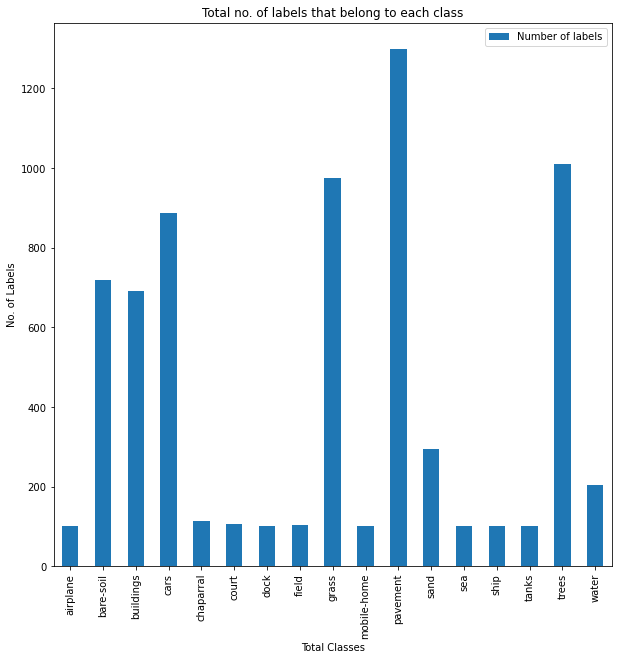

In [18]:
result = data.sum(axis="rows")
df = pd.DataFrame(result,columns=['Number of labels'])   #Convert into Data Frame
#Drop the first row
df.drop(index=df.index[0], 
        axis=0, 
        inplace=True)



print(df)
df.plot.bar(figsize=(10,10))
plt.xlabel("Total Classes")
plt.ylabel("No. of Labels")
plt.title("Total no. of labels that belong to each class")



The bar chart above shows the distribution of labels to the 21 classes provided to us. 

## Training Design

In this part, we will be creating a CNN. In order to perform CNN, we
1) Divide our data into training, test and validation. We provide 80% data to training, 10% for testing and 10% for validation. 
2) After that, we create the Convolution layer. Since we don't have have a large amount of data so we create 2 convolution layer
3) We create a dense layer that used for training the model
4) We evaluate the model in order to check whether the model is overfitting or underfitting
5) Test the model for unseen data

### Part 1:

In the first part, we divide our dataset into training test and validation. We provide 80% data to training, 10% to validation and 10% to test. We also want to 
normalize the dataset and make sure all datasets have the same size

In [19]:
def get_device(cuda_int):
    """Get Cuda-Device. If cuda_int < 0 compute on CPU."""
    if cuda_int < 0:
        print("Computation on CPU")
        device = torch.device("cpu")
    elif torch.cuda.is_available():
        print("Computation on CUDA GPU device {}".format(cuda_int))
        device = torch.device("cuda:{}".format(cuda_int))
    return device

In [20]:
#Check the device.
#device = get_device(0)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [21]:
#Data Processing: Transform the data so it can be processed by Pytorch.
# Idea taken from here: https://www.youtube.com/watch?v=9OHlgDjaE2I


# To understand Normalize, check the following link:   #To understand Normalize, check this: https://stackoverflow.com/questions/65467621/what-are-the-numbers-in-torch-transforms-normalize-and-how-to-select-them
# Also check this link for normalization: https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/

train_transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(), #0-255 -> 0-1. Also changes numpy -> Tensors
    transforms.Normalize([0.595425, 0.3518577, 0.3225522],                
                        [0.19303136, 0.12492529, 0.10577361]),
      
])
test_transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize([0.595425, 0.3518577, 0.3225522],                
                        [0.19303136, 0.12492529, 0.10577361]),
                         ])
    
validate_transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize([0.595425, 0.3518577, 0.3225522],                
                        [0.19303136, 0.12492529, 0.10577361]),
                         ])    

In [18]:
#Create a directory to divide dataset into train, test and validation

directory = "Output_folder"
  
# Parent Directory path
parent_dir = "/notebooks/Hw3_data/"
  
# Path
path = os.path.join(parent_dir, directory)
  
# Create the directory
# 'GeeksForGeeks' in
# '/home / User / Documents'
os.mkdir(path)
print("Directory '% s' created" % directory)

FileExistsError: [Errno 17] File exists: '/notebooks/Hw3_data/Output_folder'

In [47]:
#Split data into train, test and validate for all images

input_folder = '/notebooks/Hw3_data/UCMerced_LandUse/Images'
output_folder = '/notebooks/Hw3_data/Output_folder'



splitfolders.ratio(input_folder, output = output_folder, seed=1337, ratio=(.7, 0.1,0.2)) 


Copying files: 0 files [00:00, ? files/s]
Copying files: 10 files [00:00, 90.57 files/s]
Copying files: 20 files [00:00, 66.30 files/s]
Copying files: 44 files [00:00, 128.07 files/s]
Copying files: 62 files [00:00, 140.05 files/s]
Copying files: 78 files [00:00, 139.97 files/s]
Copying files: 172 files [00:00, 381.50 files/s]
Copying files: 214 files [00:01, 217.70 files/s]
Copying files: 298 files [00:01, 337.39 files/s]
Copying files: 347 files [00:01, 282.27 files/s]
Copying files: 433 files [00:01, 380.20 files/s]
Copying files: 484 files [00:01, 322.72 files/s]
Copying files: 526 files [00:02, 239.56 files/s]
Copying files: 584 files [00:02, 294.16 files/s]
Copying files: 655 files [00:02, 371.47 files/s]
Copying files: 705 files [00:02, 241.43 files/s]
Copying files: 744 files [00:02, 215.67 files/s]
Copying files: 776 files [00:03, 230.52 files/s]
Copying files: 822 files [00:03, 261.91 files/s]
Copying files: 856 files [00:03, 193.03 files/s]
Copying files: 886 files [00:03, 

In [48]:
"""
trainset, valset, testset = get_dataset(
    "/notebooks/Hw3_data/UCMerced_LandUse",
    tr_transform=train_transform,
    te_transform=test_transform,
    set_sizes=[70, 20, 10],
    multilabel=False,
)
"""

'\ntrainset, valset, testset = get_dataset(\n    "/notebooks/Hw3_data/UCMerced_LandUse",\n    tr_transform=train_transform,\n    te_transform=test_transform,\n    set_sizes=[70, 20, 10],\n    multilabel=False,\n)\n'

In [22]:
#Add data into the dataloader


trainpath = '/notebooks/Hw3_data/Output_folder/train'
valpath =  '/notebooks/Hw3_data/Output_folder/val'
testpath = '/notebooks/Hw3_data/Output_folder/test'

import torchvision

train_loader = DataLoader(torchvision.datasets.ImageFolder(trainpath, transform=train_transform), batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(torchvision.datasets.ImageFolder(valpath, transform=validate_transform), batch_size=64, shuffle=False, pin_memory=True)
test_loader = DataLoader(torchvision.datasets.ImageFolder(testpath, transform=test_transform), batch_size=64, shuffle=False, pin_memory=True)

In [23]:
# Define our classes
root= Path(trainpath)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


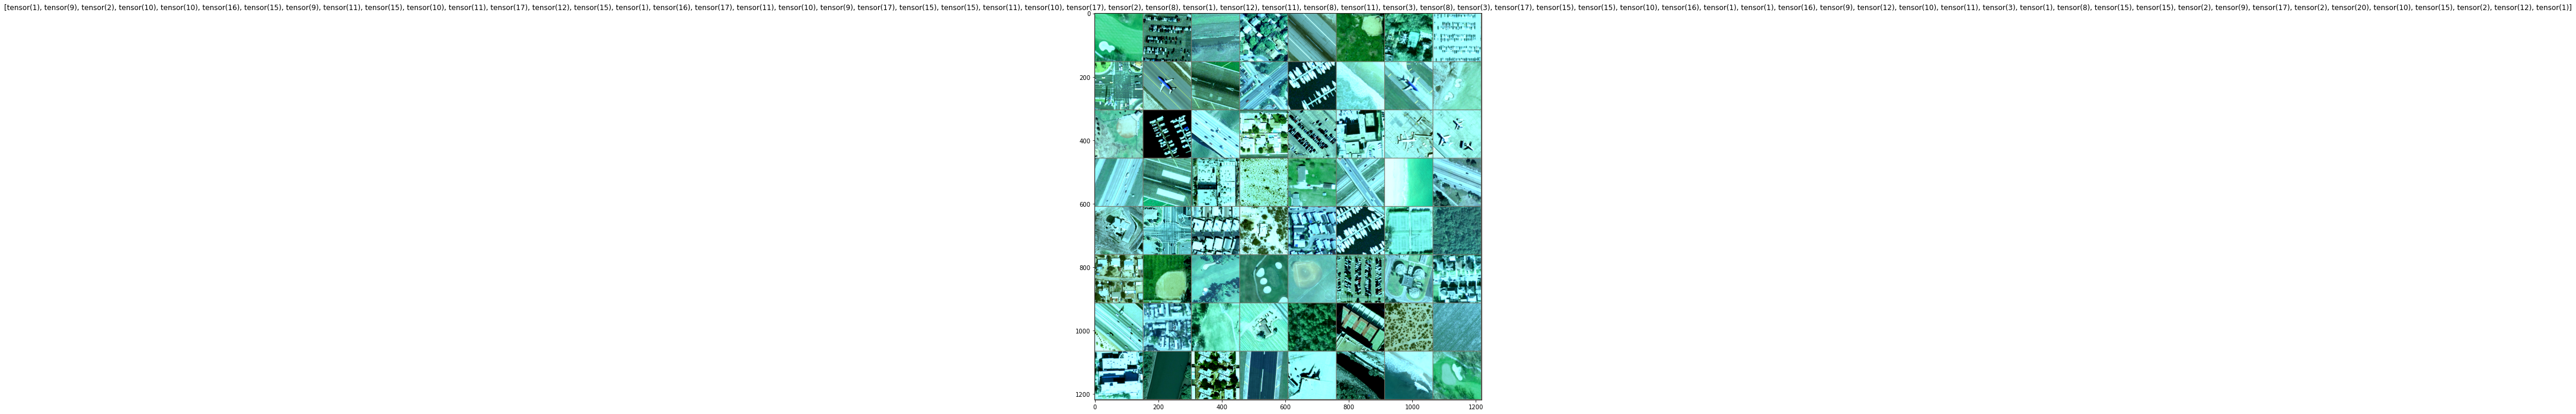

In [22]:
# Let’s visualize a few training images .

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize= (12,12,))
imshow(out, title=[classes[x] for x in classes])

## Desinging a CNN and the dense layer network
Generally we have to create a 2-3 layer CNN an before creating a dense network to perform Forward and backpropogation (please refer to line 26 of Lab07).
However, in this case we are told RESNET18. THis is an already built CNN. Hence, we don't need to create convoltuion layers and dense layer by ourself. 
We just need to adjust the values and RESNET18 will train the model by itself.

To understand RESNET18, check the following links: https://www.youtube.com/watch?v=K0lWSB2QoIQ
https://www.coursera.org/lecture/ai-deep-learning-capstone/pre-trained-models-with-resnet-18-review-pytorch-F0nDe

In [76]:
from torchvision import models
from torchvision.models import ResNet18_Weights
from torch.optim import Adam



#Criterion
criterion = nn.BCEWithLogitsLoss().to(device)        #binary cross entropy
#criterion = nn.CrossEntropyLoss().to(device) 


#Model
resnet_pretrained = models.resnet18(weights=ResNet18_Weights.DEFAULT)
resnet_pretrained.fc = nn.Linear(512, 21) #21 - number of classes
resnet_pretrained.to(device)


#Optimizer 
optimizer=Adam(   #For performing stochastic gradient descent 
    resnet_pretrained.parameters(),
    lr=0.001,
    weight_decay=0.0001) #The value of n in learning rate. Rate with which the learning rate changes


In [77]:
import glob

#Count the number of datasets in train, test, validation
train_count=len(glob.glob(trainpath+'/**/*.tif'))
test_count=len(glob.glob(testpath+'/**/*.tif'))
val_count = len(glob.glob(valpath+'/**/*.tif'))
print("Train Count = {}, Test count = {}, Validate count = {}".format(train_count, test_count, val_count))

Train Count = 1470, Test count = 420, Validate count = 210


In [82]:
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import datasets, models, transforms
import time
import time
from torch.autograd import Variable

# Taken from the following website: https://github.com/gaurav67890/Pytorch_Tutorials/blob/master/cnn-scratch-training.ipynb
# Idea taken from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


#https://discuss.pytorch.org/t/target-size-torch-size-10-must-be-the-same-as-input-size-torch-size-2/72354/7
#Define training & test model
def train_model(model, criterion, optimizer, num_epochs):
    
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        #Evaluation and training on training dataset
        model.train()
        train_accuracy=0.0
        train_loss=0.0
        
        for i, (images,labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())
        
            optimizer.zero_grad()
        
            outputs=model(images)
            #labels = labels.type_as(outputs)
            #loss=criterion(outputs.squeeze(),labels)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
        
            train_loss+= loss.cpu().data*images.size(0)
            _,prediction=torch.max(outputs.data,1)
        
            train_accuracy+=int(torch.sum(prediction==labels.data))
        
        train_accuracy=train_accuracy/train_count
        train_loss=train_loss/train_count
        
    
        #Tesing the model for validation
        model.eval()
        test_accuracy=0.0
        
        for i, (images,labels) in enumerate(val_loader):
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())
                
            outputs=model(images)
            _,prediction=torch.max(outputs.data,1)
            test_accuracy+=int(torch.sum(prediction==labels.data))
        
        test_accuracy=test_accuracy/test_count
    
    
        print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
        if test_accuracy>best_accuracy:
            torch.save(model.state_dict(),'best_checkpoint.model')
            best_accuracy=test_accuracy
    
    

In [81]:
#Training the model


#This happens because of criterion. Change the criterion
model_ft = train_model(resnet_pretrained, criterion, optimizer,
                       num_epochs=20)

ValueError: Target size (torch.Size([64])) must be the same as input size (torch.Size([64, 21]))

In [70]:
def train(
    model,
    optimizer,
    criterion,
    train_loader,
    epochs,
    device,
    scheduler=None,
    val_loader=None,
):
    """
    Training loop to optimize a network for several epochs and a specified loss.

    Args:
    -----
    model               : a PyTorch model
    optimizer           : a PyTorch optimizer
    criterion           : a PyTorch-compatible loss function, e.g. nn.CrossEntropyLoss
    train_loader        : a PyTorch trainset loader
    epochs              : int specifying the number of training epochs
    device              : torch device to use (defaults to CPU)
    scheduler (opt.)    : PyTorch scheduler
    val_loader (opt.)   : validation dataset
    """
    model.to(device)
    losses, accuracies = [0, 0], [0, 0]

    for epoch in tqdm(range(1, epochs + 1), desc="Training the network"):
        model.train()  # set model to training mode

        # Data-Loading Loop
        with tqdm(train_loader, unit=" batch") as tepoch:
            for idx, (batch, targets) in enumerate(tepoch):
                tepoch.set_description("Epoch {}".format(epoch))

                # put loaded data on GPU
                batch, targets = batch.to(device), targets.to(device)

                # zero accumulated gradients from previous batch
                optimizer.zero_grad()

                # infer predictions for batch
                output = model(batch)
                predictions = output.argmax(dim=1)

                # compute loss from predictions, CELoss automatically applies F.log_softmax
                #From here we got the idea: https://discuss.pytorch.org/t/target-size-torch-size-10-must-be-the-same-as-input-size-torch-size-2/72354/7
                targets = targets.type_as(output)
                loss = criterion(output.squeeze(), targets)
                

                # accumulate gradients for all parameter according to batch errors
                loss.backward()

                # update paramters according to accumulated gradients
                optimizer.step()

                correct = (predictions == targets).sum().item()
                accuracy = correct / train_loader.batch_size

                losses.append(loss.item())
                accuracies.append(accuracy)

                tepoch.set_postfix(loss=np.mean(losses[-50:]), accuracy=np.mean(accuracies[-50:]))

        if val_loader is not None:
            val_losses, val_accuracies = [], []

            for batch, targets in val_loader:

                # put loaded data on GPU
                batch = batch.to(device)
                targets = targets.to(device)

                output = model(batch)
                targets = targets.type_as(output)
                loss = criterion(output.squeeze(), targets)
                predictions = output.argmax(dim=1)

                correct = (predictions == targets).sum().item()
                accuracy = correct / train_loader.batch_size
                val_losses.append(loss.item())
                val_accuracies.append(accuracy)

            print(
                "Val-Loss: {:.2f}. Val-Acc: {:.2f}".format(
                    np.mean(val_losses), np.mean(val_accuracies)
                )
            )

In [71]:
train(
    model=resnet_pretrained,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    epochs=10,
    device=device,
    scheduler=None,
    val_loader=val_loader,
)

Training the network:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ? batch/s]

ValueError: Target size (torch.Size([64])) must be the same as input size (torch.Size([64, 21]))